In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
pwd

'/Users/amnon/git/dbbact-paper/revision/human-feces-japan'

In [4]:
%matplotlib inline

In [5]:
ca.set_log_level(11)

In [6]:
%matplotlib inline

In [7]:
db=ca.database._get_database_class('dbbact')

creating logger


# Load the japanese human fecal v12 and v34 datasets
Data is from: 

Kameoka, Shoichiro, et al. "Benchmark of 16S rRNA gene amplicon sequencing using Japanese gut microbiome data from the V1–V2 and V3–V4 primer sets." BMC genomics 22.1 (2021): 1-10.

(accession number: PRJNA715083)

In [10]:
dat12=ca.read_amplicon('./all.v12.biom','./map.v12.txt',normalize=10000,min_reads=1000)
dat34=ca.read_amplicon('./all.v34.biom','./map.v34.txt',normalize=10000,min_reads=1000)

2023-05-10 12:13:18 INFO loaded 192 samples, 4039 features
2023-05-10 12:13:18 INFO Loaded 192 samples, 4039 features
2023-05-10 12:13:18 INFO After filtering, 192 samples remaining.
2023-05-10 12:13:18 INFO loaded 192 samples, 2496 features
2023-05-10 12:13:18 INFO Loaded 192 samples, 2496 features
2023-05-10 12:13:18 INFO After filtering, 192 samples remaining.


In [11]:
dat12=dat12.cluster_features(10)
dat34=dat34.cluster_features(10)

2023-05-10 12:13:19 INFO After filtering, 3457 features remaining.
2023-05-10 12:13:21 INFO After filtering, 1881 features remaining.


# Let's look at the default word clouds (which include direct and linked annotations)

2023-05-10 12:13:58 INFO After filtering, 50 features remaining.
2023-05-10 12:13:58 INFO Getting dbBact annotations for 50 sequences, please wait...
2023-05-10 12:14:01 INFO got 3375 annotations
2023-05-10 12:14:01 INFO Got 17548 annotation-sequence pairs
2023-05-10 12:14:01 INFO Added annotation data to experiment. Total 3375 annotations, 50 ASVs
2023-05-10 12:14:01 INFO Found 1 experiments ([834]) matching current experiment - ignoring them.


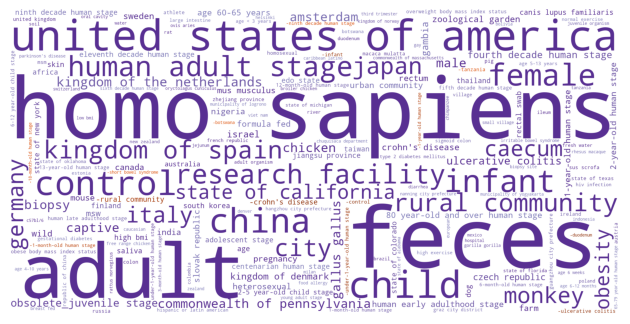

In [12]:
f=db.draw_wordcloud(dat12.filter_prevalence(0.5),ignore_exp=True)

2023-05-10 12:14:08 INFO After filtering, 40 features remaining.
2023-05-10 12:14:08 INFO Getting dbBact annotations for 40 sequences, please wait...
2023-05-10 12:14:11 INFO got 2970 annotations
2023-05-10 12:14:11 INFO Got 11670 annotation-sequence pairs
2023-05-10 12:14:11 INFO Added annotation data to experiment. Total 2970 annotations, 40 ASVs
2023-05-10 12:14:11 INFO Found 1 experiments ([835]) matching current experiment - ignoring them.


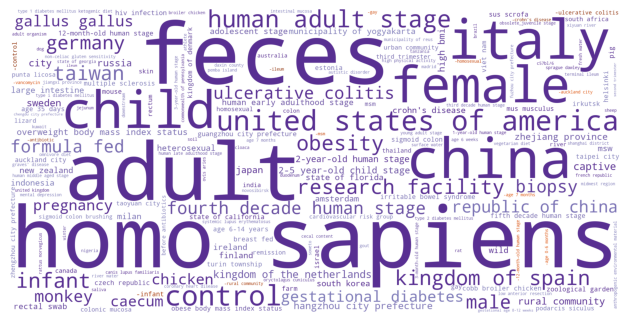

In [13]:
f=db.draw_wordcloud(dat34.filter_prevalence(0.5),ignore_exp=True)

# Compare the per-term f-scores using only annotations from a single region
We do it on the COMMON sequences (prevalence > 0.5)

In [15]:
from collections import defaultdict

def get_fscore_region(exp, region=None, max_id=None):
    # get all annotations
    db.add_all_annotations_to_exp(exp, max_id=max_id, force=True)

    if region is not None:
        print('filtering annotations for region %s' % region)
        # keep only annotations for the specified region
        anno = exp.databases['dbbact']['annotations']
        print('starting with %d annotations' % len(anno))
        anno_region=defaultdict(dict)
        for cid,cann in anno.items():
            if cann['primer']!=region:
                continue
            anno_region[cid]=cann
        print('keeping %d annotations' % len(anno_region))

        # keep only sequences with annotations from the specified region
        seqs = exp.databases['dbbact']['sequence_annotations']
        nseqs=defaultdict(list)
        annos=set(anno_region.keys())
        for cseq, cseqanno in seqs.items():
            for cann in cseqanno:
                if cann not in annos:
                    continue
                nseqs[cseq].append(cann)
        
        exp.databases['dbbact']['annotations']=anno_region
        exp.databases['dbbact']['sequence_annotations']=nseqs

    # get the f-score
    fscore, recall, precision,term_count, reduced_f =db.get_wordcloud_stats(exp, ignore_exp=True)
    return fscore


In [45]:
def plot_fscores(fs1, fs2,num_labels=0, xlabel=None,ylabel=None,title=None, specific_terms=[]):
    f=plt.figure()

    x1=[]
    y2=[]
    terms=[]
    for cterm in set(fs1.keys()).union(set(fs2.keys())):
        terms.append(cterm)
        x1.append(fs1.get(cterm,0))
        y2.append(fs2.get(cterm,0))

    plt.scatter(x1,y2,s=6)
    maxv=np.max(np.array([x1,y2]))
    plt.plot([0,maxv],[0,maxv],'k--')

    dist = np.abs(np.array(x1)-np.array(y2))/(np.array(x1)+np.array(y2))


    x1,y2,terms=zip(*sorted(zip(x1,y2,terms), key=lambda x: x[0], reverse=True))


    # add text labels to the top 20 terms (based on the x12 score)
    for i in range(num_labels):
        cterm=terms[i]
        # add the term text as non-overlapping
        plt.text(x1[i],y2[i],' '+cterm,ha='left',va='top')


        # # add the term text as non-overlapping
        # plt.text(x12[i],y34[i],cterm,ha='center',va='center',bbox=dict(facecolor='white', alpha=0.5))

        # add an arrow from the term to the point with a random offset on x and y
        # offsetx = (np.random.rand()-0.5)*0.1
        # offsety = (np.random.rand()-0.5)*0.1
        # plt.annotate('',xy=(x1[i],y2[i]),xytext=(x1[i]+offsetx,y2[i]+offsety),arrowprops=dict(arrowstyle="->"))
        # # add the term text
        # plt.text(x1[i]+offsetx,y2[i]+offsety,cterm)

    specific_terms = set(specific_terms)
    for i in range(len(terms)):
        cterm=terms[i]
        if cterm in specific_terms:
            plt.text(x1[i],y2[i],' '+cterm,ha='left',va='top',color='red')
            plt.plot([x1[i],x1[i]],[y2[i],y2[i]],'.r',markersize=6)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    return f

2023-05-10 12:29:45 INFO After filtering, 50 features remaining.
2023-05-10 12:29:45 INFO Getting dbBact annotations for 50 sequences, please wait...
2023-05-10 12:29:47 INFO got 3375 annotations
2023-05-10 12:29:47 INFO Got 17548 annotation-sequence pairs
2023-05-10 12:29:47 INFO Added annotation data to experiment. Total 3375 annotations, 50 ASVs
filtering annotations for region v3
starting with 3375 annotations
keeping 989 annotations
2023-05-10 12:29:48 INFO Found 1 experiments ([834]) matching current experiment - ignoring them.
2023-05-10 12:29:48 INFO After filtering, 40 features remaining.
2023-05-10 12:29:48 INFO Getting dbBact annotations for 40 sequences, please wait...
2023-05-10 12:29:50 INFO got 2970 annotations
2023-05-10 12:29:50 INFO Got 11670 annotation-sequence pairs
2023-05-10 12:29:50 INFO Added annotation data to experiment. Total 2970 annotations, 40 ASVs
filtering annotations for region v3
starting with 2970 annotations
keeping 997 annotations
2023-05-10 12:29:5

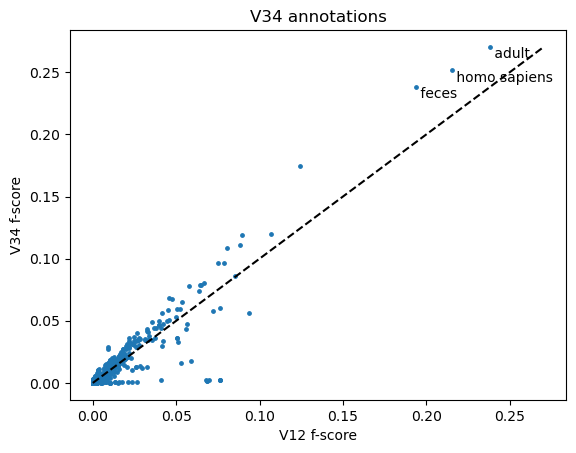

In [47]:
f=plot_fscores(get_fscore_region(dat12.filter_prevalence(0.5),'v3'), get_fscore_region(dat34.filter_prevalence(0.5),'v3'),xlabel='V12 f-score',ylabel='V34 f-score',title='V34 annotations',num_labels=3)

In [48]:
f.savefig('./fig-scatter-feces-japan.pdf',bbox_inches='tight',dpi=600)

# Load the ocean V12, V23 and V4 datasets
data from:

Wear, Emma K., et al. "Primer selection impacts specific population abundances but not community dynamics in a monthly time‐series 16S rRNA gene amplicon analysis of coastal marine bacterioplankton." Environmental microbiology 20.8 (2018): 2709-2726.

Accession: PRJNA412105


In [57]:
oceanv4=ca.read_amplicon('./table.ocean.v4.biom','./map.ocean.v4.txt',normalize=10000,min_reads=1000)
oceanv3=ca.read_amplicon('./table.ocean.v34.biom','./map.ocean.v34.txt',normalize=10000,min_reads=1000)
oceanv1=ca.read_amplicon('./table.ocean.v12.biom','./map.ocean.v12.txt',normalize=10000,min_reads=1000)


2023-05-10 17:41:09 INFO loaded 297 samples, 2557 features
2023-05-10 17:41:09 WARNING Found 93 samples that have metadata but do not have data. These samples have been dropped.
2023-05-10 17:41:09 INFO First 5 samples without data: ['SRR6131092', 'SRR6130966', 'SRR6130898', 'SRR6130896', 'SRR6130967']
2023-05-10 17:41:09 INFO Loaded 297 samples, 2557 features
2023-05-10 17:41:09 INFO After filtering, 232 samples remaining.
2023-05-10 17:41:09 INFO loaded 95 samples, 1054 features
2023-05-10 17:41:09 INFO Loaded 95 samples, 1054 features
2023-05-10 17:41:09 INFO After filtering, 93 samples remaining.
2023-05-10 17:41:09 INFO loaded 95 samples, 752 features
2023-05-10 17:41:09 INFO Loaded 95 samples, 752 features
2023-05-10 17:41:09 INFO After filtering, 94 samples remaining.


In [58]:
oceanv4=oceanv4.filter_samples('primer2',' V4')


In [59]:
oceanv4=oceanv4.cluster_features(10)
oceanv3=oceanv3.cluster_features(10)
oceanv1=oceanv1.cluster_features(10)

2023-05-10 17:41:18 INFO After filtering, 561 features remaining.
2023-05-10 17:41:18 INFO After filtering, 1020 features remaining.
2023-05-10 17:41:18 INFO After filtering, 752 features remaining.


# Let's look at the default word clouds (which include direct and linked annotations)

2023-05-10 17:41:32 INFO After filtering, 45 features remaining.
2023-05-10 17:41:32 INFO Getting dbBact annotations for 45 sequences, please wait...
2023-05-10 17:41:33 INFO got 351 annotations
2023-05-10 17:41:33 INFO Got 3045 annotation-sequence pairs
2023-05-10 17:41:33 INFO Added annotation data to experiment. Total 351 annotations, 45 ASVs
2023-05-10 17:41:33 INFO Found 1 experiments ([317]) matching current experiment - ignoring them.


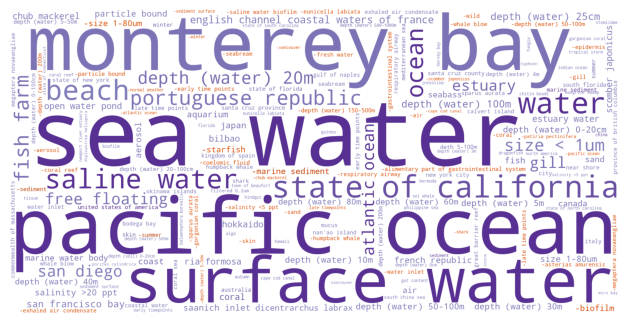

In [60]:
f=db.draw_wordcloud(oceanv4.filter_prevalence(0.5),ignore_exp=True)

2023-05-10 17:41:52 INFO After filtering, 90 features remaining.
2023-05-10 17:41:52 INFO Getting dbBact annotations for 90 sequences, please wait...
2023-05-10 17:41:53 INFO got 312 annotations
2023-05-10 17:41:53 INFO Got 2584 annotation-sequence pairs
2023-05-10 17:41:53 INFO Added annotation data to experiment. Total 312 annotations, 90 ASVs
2023-05-10 17:41:53 WARNING No experiment found matching the details [['DataMD5', 'a057928205c3edfea120f99aee874ba3'], ['MapMD5', '4f1f81b97843332f2d1a4e949b8211ad']]
2023-05-10 17:41:53 WARNING No matching experiment found in dbBact. Not ignoring any experiments


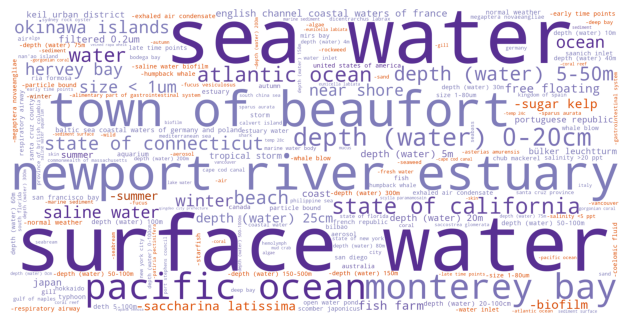

In [61]:
f=db.draw_wordcloud(oceanv3.filter_prevalence(0.5),ignore_exp=True)

2023-05-10 17:42:09 INFO After filtering, 61 features remaining.
2023-05-10 17:42:09 INFO Getting dbBact annotations for 61 sequences, please wait...
2023-05-10 17:42:11 INFO got 328 annotations
2023-05-10 17:42:11 INFO Got 2854 annotation-sequence pairs
2023-05-10 17:42:11 INFO Added annotation data to experiment. Total 328 annotations, 61 ASVs
2023-05-10 17:42:11 WARNING No experiment found matching the details [['DataMD5', '75d406e959af1fb7758d8427590ced20'], ['MapMD5', 'a5a61b4d708e32f2f15e69335498c4f0']]
2023-05-10 17:42:11 WARNING No matching experiment found in dbBact. Not ignoring any experiments


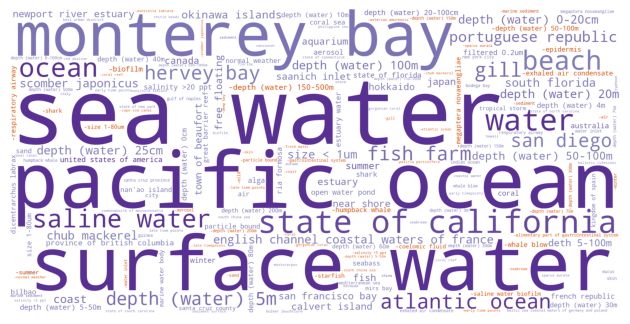

In [62]:
f=db.draw_wordcloud(oceanv1.filter_prevalence(0.5),ignore_exp=True)

# Compare the per-term f-scores using only annotations from a single region
We do it on the COMMON sequences (prevalence > 0.5)

2023-05-10 17:43:33 INFO After filtering, 90 features remaining.
2023-05-10 17:43:33 INFO Getting dbBact annotations for 90 sequences, please wait...
2023-05-10 17:43:34 INFO got 312 annotations
2023-05-10 17:43:34 INFO Got 2584 annotation-sequence pairs
2023-05-10 17:43:34 INFO Added annotation data to experiment. Total 312 annotations, 90 ASVs
filtering annotations for region v4
starting with 312 annotations
keeping 242 annotations
2023-05-10 17:43:34 WARNING No experiment found matching the details [['DataMD5', 'a057928205c3edfea120f99aee874ba3'], ['MapMD5', '4f1f81b97843332f2d1a4e949b8211ad']]
2023-05-10 17:43:34 WARNING No matching experiment found in dbBact. Not ignoring any experiments
2023-05-10 17:43:34 INFO After filtering, 45 features remaining.
2023-05-10 17:43:34 INFO Getting dbBact annotations for 45 sequences, please wait...
2023-05-10 17:43:34 INFO got 351 annotations
2023-05-10 17:43:34 INFO Got 3045 annotation-sequence pairs
2023-05-10 17:43:34 INFO Added annotation d

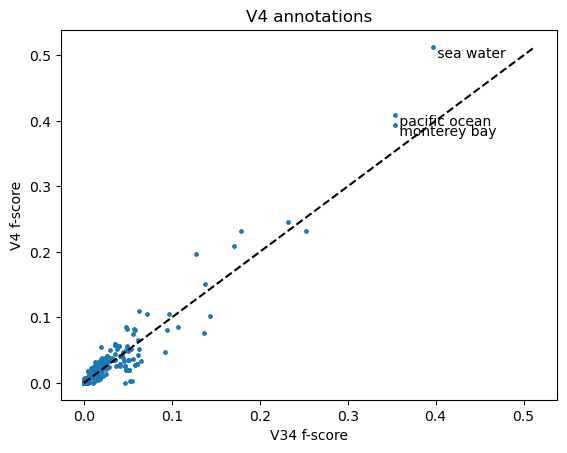

In [65]:
f=plot_fscores(get_fscore_region(oceanv3.filter_prevalence(0.5),'v4'), get_fscore_region(oceanv4.filter_prevalence(0.5),'v4'),xlabel='V34 f-score',ylabel='V4 f-score',title='V4 annotations',num_labels=3)

In [66]:
f.savefig('./fig-scatter-ocean-v34-v4.pdf',bbox_inches='tight',dpi=600)

2023-05-10 17:44:32 INFO After filtering, 61 features remaining.
2023-05-10 17:44:32 INFO Getting dbBact annotations for 61 sequences, please wait...
2023-05-10 17:44:32 INFO got 328 annotations
2023-05-10 17:44:32 INFO Got 2854 annotation-sequence pairs
2023-05-10 17:44:32 INFO Added annotation data to experiment. Total 328 annotations, 61 ASVs
filtering annotations for region v4
starting with 328 annotations
keeping 295 annotations
2023-05-10 17:44:32 WARNING No experiment found matching the details [['DataMD5', '75d406e959af1fb7758d8427590ced20'], ['MapMD5', 'a5a61b4d708e32f2f15e69335498c4f0']]
2023-05-10 17:44:32 WARNING No matching experiment found in dbBact. Not ignoring any experiments
2023-05-10 17:44:32 INFO After filtering, 45 features remaining.
2023-05-10 17:44:32 INFO Getting dbBact annotations for 45 sequences, please wait...
2023-05-10 17:44:32 INFO got 351 annotations
2023-05-10 17:44:32 INFO Got 3045 annotation-sequence pairs
2023-05-10 17:44:32 INFO Added annotation d

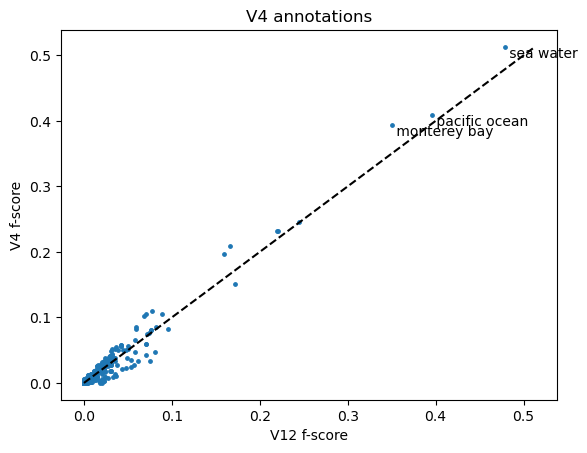

In [67]:
f=plot_fscores(get_fscore_region(oceanv1.filter_prevalence(0.5),'v4'), get_fscore_region(oceanv4.filter_prevalence(0.5),'v4'),xlabel='V12 f-score',ylabel='V4 f-score',title='V4 annotations',num_labels=3)

In [68]:
f.savefig('./fig-scatter-ocean-v12-v4.pdf',bbox_inches='tight',dpi=600)